# TRANSFER LEARNING - VGG-16
In this notebook we code VGG-16 using transfer learning

## IMPORTS

***mount drive***

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


***tensorflow version***

In [2]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


***tensorflow imports***

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications.imagenet_utils import decode_predictions

tf.__version__

'2.9.2'

***general imports***

In [4]:
import numpy as np 
import matplotlib.pyplot as plt

## LOAD AND PRE-PROCESS DATA

***construct an instance of image data generator***

to explain more, this will be used to make more images from the given dataset by randomly fliping, rotating and shifting the already existing images.

In [5]:
train_datagen = ImageDataGenerator(
    rescale = 1/255, 
    horizontal_flip = True, 
    rotation_range = 20, 
    width_shift_range = 0.2, 
    height_shift_range = 0.2
)

test_datagen = ImageDataGenerator(
    rescale = 1/255
)

***iterating through images***

In [6]:
training_iterator = train_datagen.flow_from_directory("/content/drive/MyDrive/Youtube/1 - VGG16/data/train", batch_size=10, target_size=(224, 224))
testing_iterator = test_datagen.flow_from_directory("/content/drive/MyDrive/Youtube/1 - VGG16/data/test", batch_size=10, target_size=(224, 224))

Found 336 images belonging to 5 classes.
Found 95 images belonging to 5 classes.


## MODEL ARCHITECTURE

we first check out the base model and then modify it for our own use (our own use is to detect flowers, but the base model detect cats)

### Base Model

***load pre-trained model***

In [7]:
vgg16_model = tf.keras.applications.VGG16(
    weights="imagenet",
    input_shape=(224, 224, 3),
    include_top = True
)

vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

***check model prediction example***

In [8]:
def load_process_image(file_path):

  # loading the original image
  image_original = load_img(file_path, target_size=(224, 224))
  print("Image size after loading", image_original.size)

  # converting original image to numpy array
  image_array = img_to_array(image_original)
  print("Image size after converting to number array", image_array.shape)
  
  # adding another dimension to the image
  image_batch = np.expand_dims(image_array, axis=0)
  print("Image size after expanding dimension", image_batch.shape)

  # pre-processing the image 
  image_preprocessed = tf.keras.applications.vgg16.preprocess_input(image_batch)

  return image_original, image_preprocessed

***example image model prediction***

Image size after loading (224, 224)
Image size after converting to number array (224, 224, 3)
Image size after expanding dimension (1, 224, 224, 3)
1/1 [==============================] - 2s 2s/step


[[('n02123045', 'tabby', 0.39231288)]]

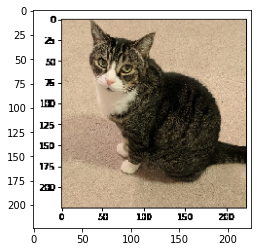

In [9]:
# setting file path
cat_path = "/content/drive/MyDrive/Youtube/1 - VGG16/cat.png"

# loading and pre-processing image 
cat_image_original, cat_image_preprocessed = load_process_image(cat_path)

# showing the original image 
plt.imshow(cat_image_original)

# predicting the class of the image 
predictions = vgg16_model.predict(cat_image_preprocessed)

# decoding the prediction 
predicted_class = decode_predictions(predictions, top=1)

predicted_class

***example image final results***

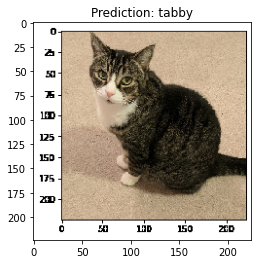

In [10]:
# showing the image 
plt.imshow(cat_image_original)

# assigning the predicted class name 
predicted_class_name = predicted_class[0][0][1]

# showing the image with the class 
_ = plt.title("Prediction: " + predicted_class_name)

### Modified Model (Transfer Learning)

***new imports***

In [11]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model

***use the pre-defined model***

In [12]:
model = VGG16(include_top=False, input_shape=(224, 224, 3))

***freeze the layers***

In [13]:
for layer in model.layers:
  layer.trainable = False

***build new model based on the pre-defined model***

In [14]:
# adding the new layers to our model output
flatten_layer = layers.Flatten()(model.output)
flattened_fc_layer = layers.Dense(512, activation="relu")(flatten_layer)
flattened_fc_softmax_layer = layers.Dense(5, activation="softmax")(flattened_fc_layer)

# building the new model using the base model and the 3 new layers
model = Model(inputs=model.inputs, outputs=flattened_fc_softmax_layer)

## TRAINING THE MODEL

***compile model***

In [15]:
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

***train model***

In [16]:
history = model.fit(training_iterator, validation_data = testing_iterator, epochs=20)

Epoch 1/20
34/34 [==============================] - 10s 252ms/step - loss: 3.1981 - accuracy: 0.4077 - val_loss: 1.3442 - val_accuracy: 0.5263
Epoch 2/20
34/34 [==============================] - 6s 164ms/step - loss: 1.1169 - accuracy: 0.6161 - val_loss: 1.3159 - val_accuracy: 0.5684
Epoch 3/20
34/34 [==============================] - 7s 202ms/step - loss: 0.8138 - accuracy: 0.6994 - val_loss: 1.2407 - val_accuracy: 0.5158
Epoch 4/20
34/34 [==============================] - 6s 164ms/step - loss: 0.7692 - accuracy: 0.7381 - val_loss: 1.4610 - val_accuracy: 0.5684
Epoch 5/20
34/34 [==============================] - 6s 190ms/step - loss: 0.6141 - accuracy: 0.7946 - val_loss: 1.1783 - val_accuracy: 0.5789
Epoch 6/20
34/34 [==============================] - 6s 170ms/step - loss: 0.4137 - accuracy: 0.8542 - val_loss: 1.9095 - val_accuracy: 0.5053
Epoch 7/20
34/34 [==============================] - 6s 171ms/step - loss: 0.5012 - accuracy: 0.8095 - val_loss: 1.4488 - val_accuracy: 0.6105
Epoch

## EVALUATE PERFORMANCE

***plotting model loss/epochs***

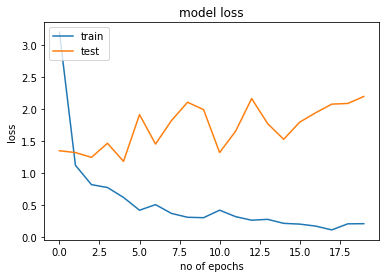

In [17]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("no of epochs")
plt.legend(["train","test"],loc="upper left")
plt.show()

***plotting model accuracy/epochs***

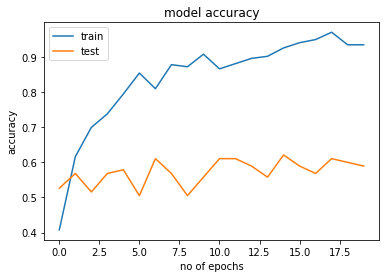

In [18]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("no of epochs")
plt.legend(["train","test"],loc="upper left")
plt.show()

***save model weights***

In [19]:
model.save("/content/drive/MyDrive/Youtube/1 - VGG16/models/TransferL_VGG16_Flower.h5")

## LOAD PRE-SAVED MODEL

we want to use the model we just saved

***new imports***

In [20]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

***load test image***

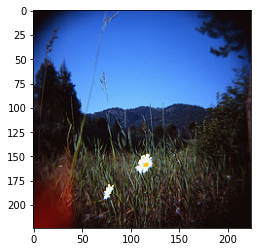

In [21]:
img = load_img("/content/drive/MyDrive/Youtube/1 - VGG16/flower.JPG", target_size=(224, 224))
plt.imshow(img)

***pre-process image***

In [22]:
img = img_to_array(img)
img = img.reshape(1,224,224,3)

***load saved model***

In [23]:
model = load_model("/content/drive/MyDrive/Youtube/1 - VGG16/models/TransferL_VGG16_Flower.h5")

***predict the image***

In [24]:
result = model.predict(img)

1/1 [==============================] - 0s 184ms/step


In [25]:
# naming the classes
class_labels = {"daisy": 0, "dandelion": 1, "rose": 2, "sunflower": 3, "tulip": 4}

# taking the number of class
result = np.argmax(result)

# translating from number of class to name of class
print([key for key in class_labels][result])

sunflower
